<a href="https://colab.research.google.com/github/nidhaloff/House_prices_prediction_keras/blob/master/Deep_Neural_Networks_for_Regression_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

## First : Processing the dataset 
We will not go deep in processing the dataset, all we want to do is getting the dataset ready to be fed into our models .

We will get rid of any features with missing values, then we will encode the categorical features, that's it.


### Load the dataset :
* Load train and test data into pandas DataFrames
* Combine train and test data to process them together

In [0]:
def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv(train_data_path)
    
    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv(test_data_path)
    
    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()

In [0]:
combined.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,2918.000000,2918.000000,...,2918.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000
mean,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,...,472.874572,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737
std,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,455.610826,169.205611,...,215.394815,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,...,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,368.500000,0.000000,...,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,733.000000,0.000000,...,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,...,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


let's define a function to get the columns that don't have any missing values 

In [0]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

Get the columns that do not have any missing values .

In [0]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

Let's see how many columns we got

In [0]:
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


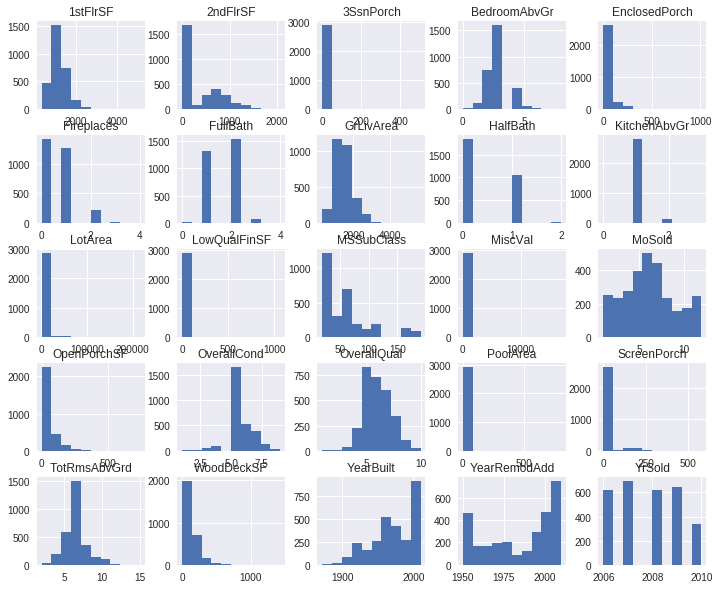

In [0]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

**The correlation between the features**

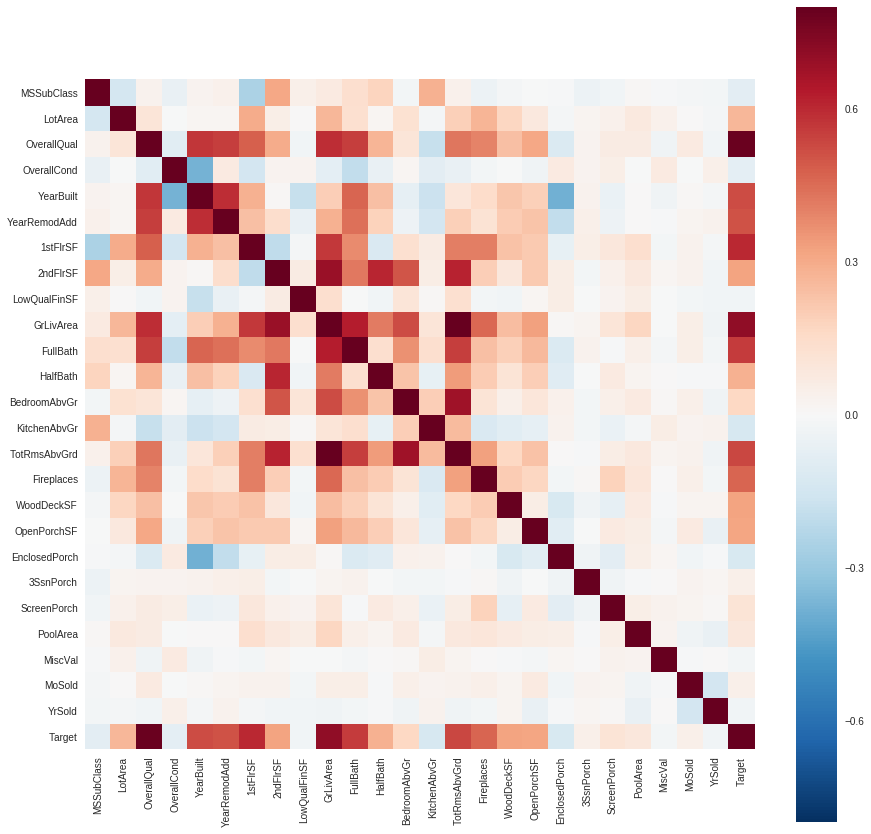

In [0]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

From the correlation heatmap above, we see that about 15 features are highly correlated with the target.

**One Hot Encode The Categorical Features :**

We will encode the categorical features using one hot encoding.

In [0]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df

In [0]:
print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 45 columns before encoding categorical features
There are 149 columns after encoding categorical features


Now, split back combined dataFrame to training data and test data 

In [0]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test 

In [0]:
train, test = split_combined()

## Second : Make the Deep Neural Network
 * Define a sequential model
 * Add some dense layers
 * Use '**relu**' as the activation function in the hidden layers
 * Use a '**normal**' initializer as the kernal_intializer 
           Initializers define the way to set the initial random weights of Keras layers.
 * We will use mean_absolute_error as a loss function
 * Define the output layer with only one node
 * Use 'linear 'as the activation function for the output layer
 


In [0]:
NN_model = Sequential()

**The Input Layer**

In [0]:
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

**The Hidden Layers**

In [0]:
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

**The Output Layer**

In [0]:
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

**Compile the network**

In [0]:
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               19200     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 184,065
Trainable params: 184,065
Non-trainable params: 0
_________________________________________________________________


**Define a checkpoint callback :**

In [0]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

## Third : Train the model :

In [0]:
NN_model.fit(train, target, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Train on 1168 samples, validate on 292 samples
Epoch 1/500
1168/1168 [==============================] - 0s 266us/step - loss: 19251.8903 - mean_absolute_error: 19251.8903 - val_loss: 23041.8968 - val_mean_absolute_error: 23041.8968

Epoch 00001: val_loss did not improve from 21730.93555
Epoch 2/500
1168/1168 [==============================] - 0s 268us/step - loss: 18180.4985 - mean_absolute_error: 18180.4985 - val_loss: 22197.7991 - val_mean_absolute_error: 22197.7991

Epoch 00002: val_loss did not improve from 21730.93555
Epoch 3/500
1168/1168 [==============================] - 0s 247us/step - loss: 19741.2386 - mean_absolute_error: 19741.2386 - val_loss: 25841.9880 - val_mean_absolute_error: 25841.9880

Epoch 00003: val_loss did not improve from 21730.93555
Epoch 4/500
1168/1168 [==============================] - 0s 246us/step - loss: 18684.5058 - mean_absolute_error: 18684.5058 - val_loss: 21956.6884 - val_mean_absolute_error: 21956.6884

Epoch 00004: val_loss did not improve from 2

In [0]:
# Load wights file of the best model :
wights_file = 'Weights-478--18738.19831.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])